## Loading Data


In [4]:
from time import time, localtime, strftime
t00 = time()
import numpy as np
import pandas as pd

In [5]:
import boto3
BUCKET_NAME = 'ramcell-dev-spectra-source'
OBJECT_NAME = 'Glucose 500mW 10sec.txt'
s3 = boto3.client('s3')
    
s3.download_file(BUCKET_NAME, OBJECT_NAME,'inference_target_data.txt')

In [9]:
data = pd.read_csv('inference_target_data.txt', sep="\t", header=None)

In [21]:
np.arange(0,1000)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

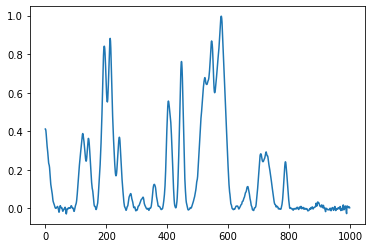

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
data_npy = data[1].to_numpy()
input_data = np.interp(np.arange(0,1000),np.linspace(0,1000,num=data_npy.shape[0]),data_npy)
plt.plot(np.arange(0,1000),input_data)
X = input_data.reshape(1,1000)

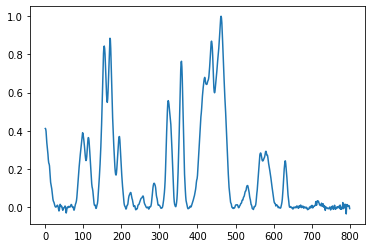

In [30]:
plt.plot(data_npy)


## Loading pre-trained CNN


In [31]:
from resnet import ResNet
import os
import torch

In [32]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1000
in_channels = 64
n_classes = 30

GPU_NUM = 3 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check
if device != 'cpu' : cuda = True

Current cuda device  2


In [33]:
# Load trained weights for demo
cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                in_channels=in_channels, n_classes=n_classes)
cnn.cuda()
cnn.load_state_dict(torch.load(
    './finetuned_22-07-17-11-22.ckpt', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [45]:
print(input_data.shape)
y = np.array([0])

(1000,)


(1, 1000)

### Train/val split
We split the fine-tuning dataset into train and validation sets. We randomly sample 10% of the dataset to use as a validation set.

In [57]:
from training import get_predictions
from datasets import spectral_dataloader

dl_test = spectral_dataloader(X, y,batch_size=1,num_workers=1)
preds_test, corr_test = get_predictions(cnn,dl_test,cuda)
prob_test= get_predictions(cnn,dl_test,cuda,get_probs=True)

print(preds_test,corr_test,prob_test)
print("train accuracy = {}%".format(corr_test/1*100))

[27] 0 [[6.3968636e-10 7.0735995e-13 4.5107615e-09 9.8130007e-14 2.4486875e-12
  1.7372408e-12 4.5400466e-21 1.2911078e-17 8.6191084e-14 3.9316110e-05
  1.4008052e-10 2.3127211e-09 2.7135056e-17 3.0382576e-13 6.1215089e-26
  2.6362528e-13 3.7042109e-11 6.5224136e-16 2.8720414e-02 9.1190341e-27
  1.8286423e-15 2.4442026e-09 2.5195683e-09 1.5090598e-07 5.0183149e-17
  6.0392555e-13 2.2850792e-17 9.7124016e-01 2.4318293e-12 7.8796491e-13]]
train accuracy = 0.0%


In [59]:
prob_test.argsort()

array([[19, 14,  6,  7, 26, 12, 24, 17, 20,  8,  3, 15, 13, 25,  1, 29,
         5, 28,  4, 16, 10,  0, 11, 21, 22,  2, 23,  9, 18, 27]])

In [7]:
p_val = 0.1
n_val = int(3000 * p_val)
idx_tr = list(range(3000))
np.random.shuffle(idx_tr)
idx_val = idx_tr[:n_val]
idx_tr = idx_tr[n_val:]

# Fine-tune CNN
epochs = 30 # Change this number to ~30 for full training
batch_size = 500
t0 = time()
# Set up Adam optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
# Set up dataloaders
dl_tr = spectral_dataloader(X, y, idxs=idx_tr,
    batch_size=batch_size, shuffle=True)
dl_val = spectral_dataloader(X, y, idxs=idx_val,
    batch_size=batch_size, shuffle=False)

In [8]:

# Fine-tune CNN for first fold
best_val = 0
no_improvement = 0
max_no_improvement = 5
print('Starting Fine-tune!')
for epoch in range(epochs):
    print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
    # Train
    acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
        training=True, optimizer=optimizer)
    print('  Train acc: {:0.2f}'.format(acc_tr))
    # Val
    acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
        training=False, optimizer=optimizer)
    print('  Val acc  : {:0.2f}'.format(acc_val))
    # Check performance for early stopping
    if acc_val > best_val or epoch == 0:
        best_val = acc_val
        no_improvement = 0
        best_model = cnn
    else:
        no_improvement += 1
    if no_improvement >= max_no_improvement:
        print('Finished after {} epochs!'.format(epoch+1))
        break

torch.save(best_model.state_dict()
           ,'finetuned_'+strftime('%y-%m-%d-%H-%M',localtime(t00))+'.ckpt')

print('\n completed in: {:0.2f}s'.format(time()-t00))

Starting Fine-tune!
 Epoch 1: 0.01s
  Train acc: 65.41
  Val acc  : 75.33
 Epoch 2: 2.57s
  Train acc: 81.96
  Val acc  : 85.33
 Epoch 3: 4.85s
  Train acc: 87.44
  Val acc  : 88.33
 Epoch 4: 7.06s
  Train acc: 92.26
  Val acc  : 88.67
 Epoch 5: 9.33s
  Train acc: 94.52
  Val acc  : 91.67
 Epoch 6: 11.58s
  Train acc: 96.89
  Val acc  : 94.00
 Epoch 7: 13.90s
  Train acc: 98.19
  Val acc  : 92.67
 Epoch 8: 16.17s
  Train acc: 98.96
  Val acc  : 93.33
 Epoch 9: 18.48s
  Train acc: 99.63
  Val acc  : 94.00
 Epoch 10: 20.79s
  Train acc: 99.81
  Val acc  : 93.33
 Epoch 11: 23.15s
  Train acc: 100.00
  Val acc  : 94.00
Finished after 11 epochs!

 completed in: 29.32s


The accuracies seen here are not representative of the accuracies achieved when training on the full dataset until convergence. To do this, increase the number of epoches. This code demonstrates how a pre-trained CNN can be fine-tuned and evaluated using randomly selected train/validation splits.

In [9]:
from training import get_predictions
import numpy as np

In [10]:
X_test = './data/X_test.npy'
y_test = './data/y_test.npy'
X = np.load(X_test)
y = np.load(y_test)
print(X.shape, y.shape)
dl_test = spectral_dataloader(X, y, batch_size=batch_size, shuffle=True)

(3000, 1000) (3000,)


In [12]:
preds_tr, corr_tr = get_predictions(best_model,dl_tr,cuda)
preds_val, corr_val = get_predictions(best_model,dl_val,cuda)
preds_test, corr_test = get_predictions(best_model,dl_test,cuda)
print("train accuracy = {}%".format(corr_tr/2700*100))
print("validation accuracy = {}%".format(corr_val/300*100))
print("test accuracy = {}%".format(corr_test/3000*100))

train accuracy = 100.0%
validation accuracy = 94.0%
test accuracy = 83.13333333333334%
